In [1]:
# 데이터 분석을 위한 패키지
import numpy as np
import pandas as pd

In [2]:
# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import FinanceDataReader as fdr

In [4]:
import koreanize_matplotlib

In [5]:
import datetime
from dateutil.relativedelta import relativedelta

In [14]:
# 모든 컬럼,행을 출력하도록 설정
pd.set_option('display.max_columns', None) # None으로 설정하면 모든 컬럼 출력
pd.set_option('display.max_rows', None) #None으로 설정하면 모든 행 출력

In [7]:
df = pd.read_csv('sector_by_stock_list_df.csv')

In [26]:
kospi = pd.read_csv('kospi_add_sector_2024-12-28.csv')
kosdaq = pd.read_csv('kosdaq_add_sector_2024-12-28.csv')

In [16]:
kospi.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Sector
0,005930,KR7005930003,삼성전자,KOSPI,NaN,53700,1,100,0.19,53500,54100,53200,10747196,576022861800,320577322935000,5969782550,STK,반도체와반도체장비
1,000660,KR7000660001,SK하이닉스,KOSPI,NaN,174500,1,4400,2.59,170100,176000,170000,2643523,459886497400,127036412692500,728002365,STK,반도체와반도체장비
2,373220,KR7373220003,LG에너지솔루션,KOSPI,NaN,348000,1,3500,1.02,341000,350500,340500,200696,69426924500,81432000000000,234000000,STK,전기제품
3,207940,KR7207940008,삼성바이오로직스,KOSPI,NaN,934000,2,-3000,-0.32,933000,940000,920000,35257,32796380000,66476516000000,71174000,STK,제약
4,005380,KR7005380001,현대차,KOSPI,NaN,215000,2,-2500,-1.15,217000,217500,213500,391681,84299329000,45024481065000,209416191,STK,자동차


시장 내 각 업종별 변동성 계산



In [8]:
# n개월 전 날짜 계산 함수(개월단위)
def calculate_start_date(months_ago, end_date):
    start_date = datetime.datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months_ago)
    return start_date.strftime('%Y-%m-%d')

# 오늘 날짜 구하기
today = datetime.datetime.today()
today_str = today.strftime('%Y-%m-%d')

In [17]:
def volatility_by_stock(market=str, month_ago = 1, end_date=today_str):
    """
    주어진 시장(KOSPI 또는 KOSDAQ)의 각 종목에 대한 변동성을 계산하는 함수.

    Parameters:
    market (str): 'KOSPI' 또는 'KOSDAQ' 중 하나를 선택하여 해당 시장의 종목을 대상으로 변동성을 계산.
    month_ago (int): 계산할 시작 날짜로부터 몇 개월 전부터 수익률을 계산할 것인지 지정.
    end_date (str, optional): 데이터 조회의 종료 날짜 (형식: 'YYYY-MM-DD'). 기본값은 오늘 날짜.

    Returns:
    pd.DataFrame: 각 종목의 코드, 이름, 변동성(백분율) 정보를 포함하는 데이터프레임.
    
    예외 처리:
    데이터 로드 중 오류가 발생하면 해당 종목에 대한 오류 메시지를 출력.
    """
    
    start_date = calculate_start_date(month_ago, end_date)

    # 변동성을 저장할 리스트
    volatility_list = []
    
     # 시장 데이터 선택
    if market == 'KOSPI':
        sector_data = kospi
    elif market == 'KOSDAQ':
        sector_data = kosdaq
    else:
        raise ValueError(" 'KOSPI', 'KOSDAQ' 두 시장만 지원하는 기능입니다.")    
        
    # 각 종목의 데이터를 가져와 변동성 계산
    
    for index, row in sector_data.iterrows():
        ticker = row['Code']
        try:
            # 각 종목의 데이터 가져오기 
            data = fdr.DataReader(ticker, start=start_date, end=end_date)
            data['Returns'] = data['Close'].pct_change()  # 수익률 계산
            
            # 변동성 계산 (표준편차)
            volatility = data['Returns'].std() * 100  # 백분율로 변환
            volatility_list.append({'Code': ticker, 'Name': row['Name'], 'Volatility': volatility})
        except Exception as e:
            print(f"{ticker} 데이터 오류: {e}")

    # 변동성 DataFrame 생성
    volatility_df = pd.DataFrame(volatility_list)
    
    return volatility_df


In [18]:
tmp = volatility_by_stock(market='KOSPI')

In [19]:
tmp.head()

,Code,Name,Volatility
0,005930,삼성전자,1.620596
1,000660,SK하이닉스,2.300046
2,373220,LG에너지솔루션,2.717703
3,207940,삼성바이오로직스,1.389048
4,005380,현대차,2.109992


In [27]:
# 개선된 함수

# 반복문의 사용을 줄이고, 중복 코드를 줄인 형태

# merge를 통해 두 df를 결합하였기 때문에, 대량의 데이터 소화시 성능향상이 기대

def add_sector_info(market):
  
    # 종목 데이터 가져오기
    df = volatility_by_stock(market=market, month_ago=1)
    
    # KOSPI 또는 KOSDAQ 데이터프레임 선택
    if market == 'KOSPI':
        sector_data = kospi
    elif market == 'KOSDAQ':
        sector_data = kosdaq
    else:
        raise ValueError(" 'KOSPI', 'KOSDAQ' 두 시장만 지원하는 기능입니다.")

    # 'Code'를 인덱스로 설정
    sector_data = sector_data.set_index('Code')

    # 업종과 종목명 추가
    df = df.merge(sector_data['Sector'], left_on='Code', right_index=True, how='left')
    return df

In [28]:
kospi_volatility_df = add_sector_info(market='KOSPI')

In [29]:
kospi_volatility_df.head()

,Code,Name,Volatility,Sector
0,005930,삼성전자,1.620596,반도체와반도체장비
1,000660,SK하이닉스,2.300046,반도체와반도체장비
2,373220,LG에너지솔루션,2.717703,전기제품
3,207940,삼성바이오로직스,1.389048,제약
4,005380,현대차,2.109992,자동차


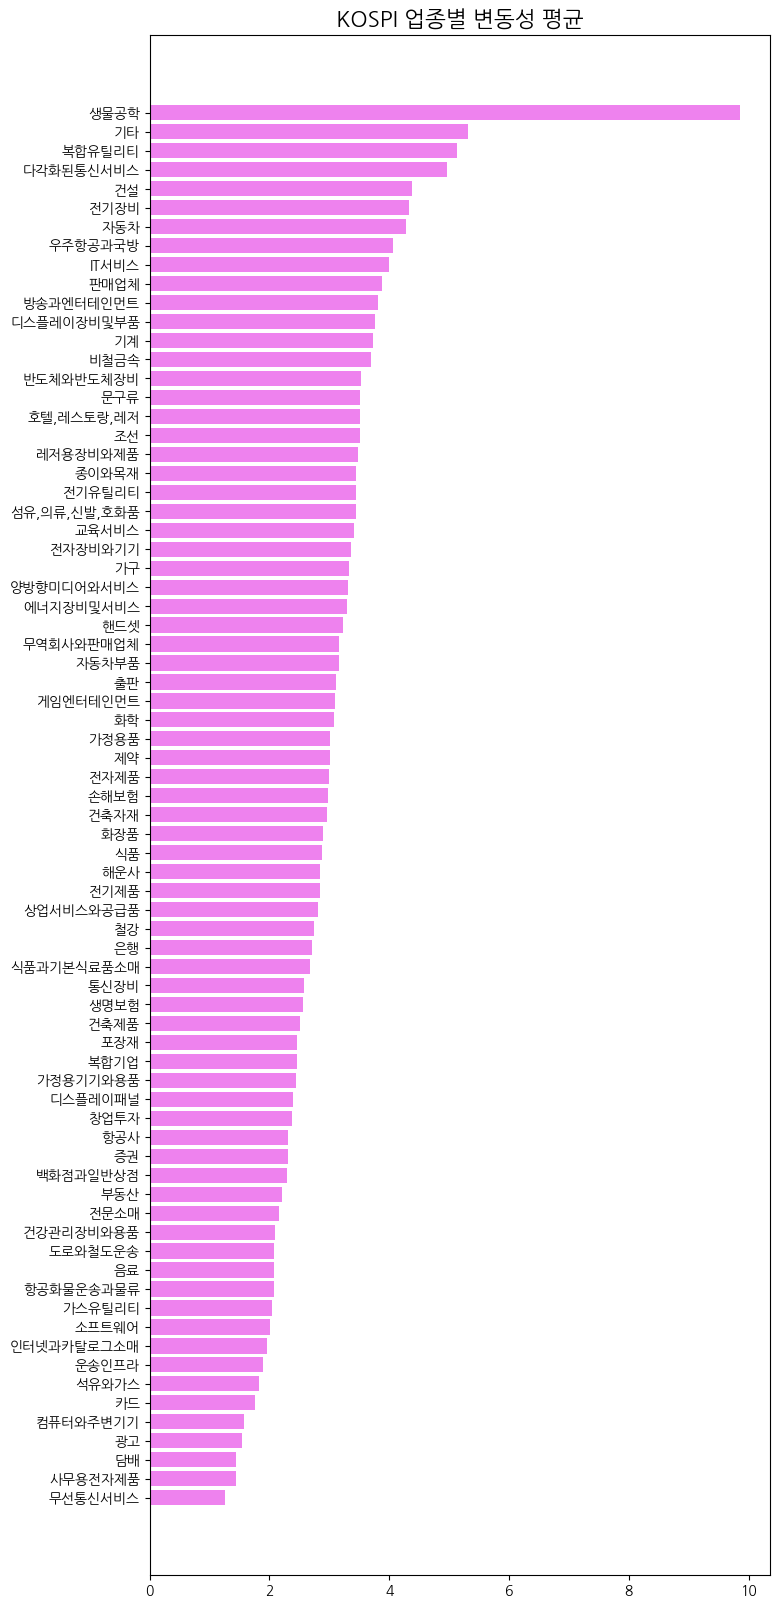

In [36]:
mean_volatility_by_sector = kospi_volatility_df.groupby('Sector').agg({'Volatility':'mean'}).sort_values(by='Volatility', ascending=True)
  
plt.figure(figsize=(8,20))
plt.barh(mean_volatility_by_sector.index, mean_volatility_by_sector['Volatility'], color='violet')
plt.title('KOSPI 업종별 변동성 평균', fontsize=16)
plt.show()

In [39]:
# 업종별 변동성 평균을 계산하고 시각화하는 함수

def avg_volatility_by_sector(market=str) :
  mean_value_by_sector = add_sector_info(market=market).groupby('Sector').agg({'Volatility':'mean'}).sort_values(by='Volatility', ascending=True)
  
  plt.figure(figsize=(8,20))
  plt.barh(mean_value_by_sector.index, mean_value_by_sector['Volatility'], color='violet')
  plt.title(f'{market} 업종별 변동성 평균', fontsize=16)
  plt.show()
  

In [ ]:
# 함수개선 - 업종별 특정 value 평균을 계산하고 시각화 하는 함수

def avg_value_by_sector(market=str, month_ago = 1, value=str) :
  '''
  주어진 시장의 업종별 특정 값의 평균을 계산하고 시각화하는 함수.

  Parameters:
  market (str): 'KOSPI' 또는 'KOSDAQ' 중 하나.
  month_ago (int): 계산할 시작 날짜로부터 몇 개월 전부터 value를 계산할 것인지 지정.
  value (str): 평균을 계산할 열의 이름. 'Volatility' - 변동성, 'TotalReturn' - 수익률

  Returns:
  None: 시각화된 결과를 출력함.
  '''
  try:
    sector_data = add_sector_info(market=market, month_ago=month_ago)
  
    # value 열 존재 확인
    if value not in sector_data.columns:
      raise ValueError(f"'{value}' 열이 데이터에 존재하지 않습니다.")
    
    mean_value_by_sector = add_sector_info(market=market, month_ago=month_ago).groupby('Sector').agg({f'{value}':'mean'}).sort_values(by=value, ascending=True)
    
    plt.figure(figsize=(8,20))
    plt.barh(mean_value_by_sector.index, mean_value_by_sector[value], color='violet')
    plt.title(f'{market} 업종별 {value} 평균', fontsize=16)
    plt.show()
    
  except Exception as e:
    print(f"예상치 못한 오류 발생: {e}")

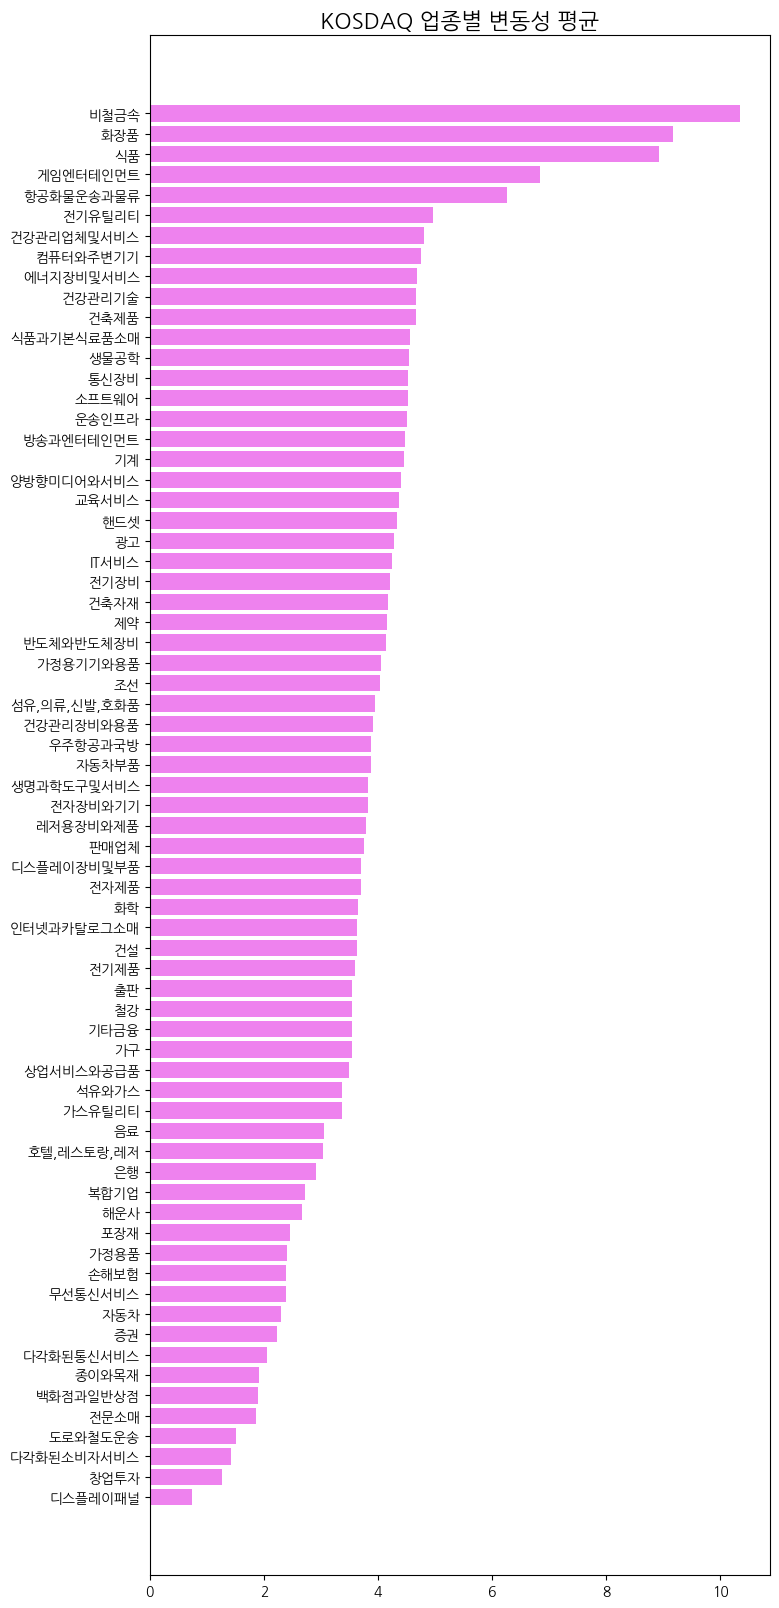

In [40]:
avg_volatility_by_sector('KOSDAQ')